# Evaluate CTGAN on eICU cardiorespiratory past history data

In [ ]:
#!pip install sdv

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import ctgan
from ctgan import CTGANSynthesizer
#from ctgan import load_demo

# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.getcwd()

'/home/dianam/Documents/data_science/PlayGround/DS6050/CTGAN_Distribution'

In [ ]:
# create the reverse one hot encoded data
"""
# load the CTGAN demo data
data = pd.read_csv('examples\csv\patients_allpasthistory_onehot_cardiorespiratory.csv')
data.columns

os.chdir('../eICU_gan/dataprep')
#os.getcwd()

from create_eICU_data import reverse_one_hot

os.chdir('../../CTGAN_Distribution')
#os.getcwd()

new_df = reverse_one_hot(data, columns=['ethnicity_AfricanAmerican',
       'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_NativeAmerican', 'ethnicity_Other/Unknown'], prefix='ethnicity_', new_col='ethnicity')
#new_df.head()

new_df = reverse_one_hot(new_df, columns=['gender_Female','gender_Male'], prefix='gender_', new_col='gender')

new_df = reverse_one_hot(new_df, columns=['dischargestatus_Alive', 'dischargestatus_Expired'], prefix='dischargestatus_', new_col='dischargestatus')

#new_df.head()

print(new_df.columns)
# set the names of the demo data columns that are discrete

# save the eICU data without one hot encoded values so we can re-use it
new_df.to_csv('examples/csv/patients_cardiorespiratory_textcats.csv', index=False)
"""

In [5]:
new_df = pd.read_csv('examples/csv/patients_cardiorespiratory_textcats.csv')

In [6]:
new_df.columns

Index(['age', 'hospitaldischargeoffset', 'CHF', 'COPD_moderate',
       'COPD_nolimitations', 'COPD_severe', 'NoHealthProblems', 'asthma',
       'homeoxygen', 'hypertensionrequiringtreatment',
       'restrictivepulmonarydisease', 'All', 'ethnicity', 'gender',
       'dischargestatus'],
      dtype='object')

In [7]:
discrete_columns = [
    'CHF', 'COPD_moderate',
       'COPD_nolimitations', 'COPD_severe', 'NoHealthProblems', 'asthma',
       'homeoxygen', 'hypertensionrequiringtreatment',
       'restrictivepulmonarydisease', 'All', 'ethnicity', 'gender',
       'dischargestatus'
]

In [13]:
# create the dataframe format and csv file to save evaluations of the CTGAN
# columns will be number epoch, generator loss, discriminator loss, number of generated samples, 
# CSTest Value ours vs real, KSTest Value ours vs real, 
# CSTest Value real train/test, KSTest Value real train/test,
# MulticlassDecisionTreeClassifier for COPD_severe, MulticlassMLPClassifier for COPD_severe, 
# MulticlassDecisionTreeClassifier for CHF, MulticlassMLPClassifier for CHF
# MulticlassDecisionTreeClassifier for dischargestatus, MulticlassMLPClassifier for dischargestatus
# MulticlassDecisionTreeClassifier for COPD_severe, MulticlassMLPClassifier for COPD_severe - real train/test split, 
# MulticlassDecisionTreeClassifier for CHF, MulticlassMLPClassifier for CHF - real train/test split, 
# MulticlassDecisionTreeClassifier for dischargestatus, MulticlassMLPClassifier for dischargestatus - real train/test split, 

df_CTGAN_eval = pd.DataFrame(columns=['epochs', 'time', 'distributed', 'num_generated_samples', 
'CSTest_Value_ours_v_real', 'KSTest_Value_ours_v_real', 'CSTest_Value_real_train_test', 'KSTest_Value_real_train_test',
'COPD_severe_MulticlassDecisionTreeClassifier', 'COPD_severe_MulticlassMLPClassifier', 
'CHF_MulticlassDecisionTreeClassifier', 'CHF_MulticlassMLPClassifier', 
'NoHealthProblems_MulticlassDecisionTreeClassifier', 'NoHealthProblems_MulticlassMLPClassifier', 
'dischargestatus_MulticlassDecisionTreeClassifier', 'dischargestatus_MulticlassMLPClassifier',
'realsplit_COPD_severe_MulticlassDecisionTreeClassifier', 'realsplit_COPD_severe_MulticlassMLPClassifier',
'realsplit_CHF_MulticlassDecisionTreeClassifier', 'realsplit_CHF_MulticlassMLPClassifier', 
'realsplit_dischargestatus_MulticlassDecisionTreeClassifier', 'realsplit_dischargestatus_MulticlassMLPClassifier',
'realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier', 'realsplit_NoHealthProblems_MulticlassMLPClassifier'
])

# save the evaluation dataframe to a csv file
# LEAVE THIS COMMENTED OUT UNLESS YOU WANT TO OVERWRITE 
df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)

#df_CTGAN_eval.head()

# load the evaluation dataframe from the csv file
df_CTGAN_eval = pd.read_csv('examples/csv/CTGAN_eval.csv')
print(df_CTGAN_eval.shape)
df_CTGAN_eval.head()

(0, 24)


,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,...,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier


In [ ]:
import time
from sdv.evaluation import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sdv.metrics.tabular import MulticlassDecisionTreeClassifier, MulticlassMLPClassifier
from sklearn.model_selection import train_test_split

lst_num_epochs = [10,1000,5000,10000,15000,20000,25000]
lst_distributed = [True,False]
lst_num_samples = [2500,5000]

for e in lst_num_epochs:
    for dis in lst_distributed:
        for ns in lst_num_samples:

            print("===" * 30)
            print("num epochs: ", e)
            print("distributed: ", dis)
            print("num samples: ", ns)

            # initialze the CTGAN for 10 epochs, verbose, and both the generator and discriminator distributed
            ctgan = CTGANSynthesizer(epochs=e, verbose=False, distribute_g=dis, distribute_d=dis)

            # start the timer
            start_time = time.time()

            # fit the data == train CTGAN
            ctgan.fit(new_df, discrete_columns)

            end_time = time.time()
            total_time = end_time - start_time

            # gererate samples to evaluate the CTGAN
            samples = ctgan.sample(ns)

            # create a train/test split of the real data
            df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=314)

            print(" ")
            print("Individual evaluation scores for real data train / test split: ")
            df_eval_real = evaluate(df_test, df_train, metrics=['CSTest', 'KSTest'], aggregate=False)
            real_CSTest_score = df_eval_real.query('metric == "CSTest"')['normalized_score'].values[0]
            real_KSTest_score = df_eval_real.query('metric == "KSTest"')['normalized_score'].values[0]
            print("real CSTest score: ", real_CSTest_score)
            print("real KSTest score: ", real_KSTest_score)
 
            print(" ")
            print("Individual evaluation scores for real data and CTGAN data: ")
            df_eval_ctgan = evaluate(new_df, samples, metrics=['CSTest', 'KSTest'], aggregate=False)

            ctgan_CSTest_score = df_eval_ctgan.query('metric == "CSTest"')['normalized_score'].values[0]
            ctgan_KSTest_score = df_eval_ctgan.query('metric == "KSTest"')['normalized_score'].values[0]

            print("CTGAN CSTest score: ", ctgan_CSTest_score)
            print("CTGAN KSTest score: ", ctgan_KSTest_score)

            # COPD severe evaluation
            treeclassifier_COPDsevere_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='COPD_severe')
            mlpclassifier_COPDsevere_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='COPD_severe')
            treeclassifier_COPDsevere_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='COPD_severe')
            mlpclassifier_COPDsevere_real = MulticlassMLPClassifier.compute(df_test, df_train, target='COPD_severe')

            #CHF evaluation
            treeclassifier_CHF_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='CHF')
            mlpclassifier_CHF_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='CHF')
            treeclassifier_CHF_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='CHF')
            mlpclassifier_CHF_real = MulticlassMLPClassifier.compute(df_test, df_train, target='CHF')

            # dischargestatus evaluation
            treeclassifier_dischargestatus_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='dischargestatus')
            mlpclassifier_dischargestatus_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='dischargestatus')
            treeclassifier_dischargestatus_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='dischargestatus')
            mlpclassifier_dischargestatus_real = MulticlassMLPClassifier.compute(df_test, df_train, target='dischargestatus')

            # NoHealthProblems evaluation
            treeclassifier_NoHealthProblems_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='NoHealthProblems')
            mlpclassifier_NoHealthProblems_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='NoHealthProblems')
            treeclassifier_NoHealthProblems_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='NoHealthProblems')
            mlpclassifier_NoHealthProblems_real = MulticlassMLPClassifier.compute(df_test, df_train, target='NoHealthProblems')

            df_CTGAN_eval.loc[len(df_CTGAN_eval.index)] = [e, total_time, dis,
            ns, ctgan_CSTest_score, 
            ctgan_KSTest_score, real_CSTest_score, 
            real_KSTest_score, 
            treeclassifier_COPDsevere_ctgan, 
            mlpclassifier_COPDsevere_ctgan, 
            treeclassifier_CHF_ctgan, mlpclassifier_CHF_ctgan,
            treeclassifier_NoHealthProblems_ctgan, 
            mlpclassifier_NoHealthProblems_ctgan,
            treeclassifier_dischargestatus_ctgan, 
            mlpclassifier_dischargestatus_ctgan,
            treeclassifier_COPDsevere_real, 
            mlpclassifier_COPDsevere_real, 
            treeclassifier_CHF_ctgan, mlpclassifier_CHF_real,
            treeclassifier_NoHealthProblems_real, 
            mlpclassifier_NoHealthProblems_real,
            treeclassifier_dischargestatus_real, 
            mlpclassifier_dischargestatus_real]


df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)
df_CTGAN_eval.head()

        


num epochs:  10
distributed:  True
num samples:  2500
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9868813114813882
 
Individual evaluation scores for real data and CTGAN data: 
CTGAN CSTest score:  0.9884711244821958
CTGAN KSTest score:  0.9479685906923203
num epochs:  10
distributed:  True
num samples:  5000
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9868813114813882
 
Individual evaluation scores for real data and CTGAN data: 
CTGAN CSTest score:  0.9372130377257667
CTGAN KSTest score:  0.9374210985035356
num epochs:  10
distributed:  False
num samples:  2500
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9868813114813882
 
Individual evaluation scores for real data and CTGAN data: 
CTGAN CSTest score:  0.9766910621818908
CTGAN KSTest score:

In [14]:
df_CTGAN_eval.columns

Index(['epochs', 'time', 'distributed', 'num_generated_samples',
       'CSTest_Value_ours_v_real', 'KSTest_Value_ours_v_real',
       'CSTest_Value_real_train_test', 'KSTest_Value_real_train_test',
       'COPD_severe_MulticlassDecisionTreeClassifier',
       'COPD_severe_MulticlassMLPClassifier',
       'CHF_MulticlassDecisionTreeClassifier', 'CHF_MulticlassMLPClassifier',
       'NoHealthProblems_MulticlassDecisionTreeClassifier',
       'NoHealthProblems_MulticlassMLPClassifier',
       'dischargestatus_MulticlassDecisionTreeClassifier',
       'dischargestatus_MulticlassMLPClassifier',
       'realsplit_COPD_severe_MulticlassDecisionTreeClassifier',
       'realsplit_COPD_severe_MulticlassMLPClassifier',
       'realsplit_CHF_MulticlassDecisionTreeClassifier',
       'realsplit_CHF_MulticlassMLPClassifier',
       'realsplit_dischargestatus_MulticlassDecisionTreeClassifier',
       'realsplit_dischargestatus_MulticlassMLPClassifier',
       'realsplit_NoHealthProblems_MulticlassDe

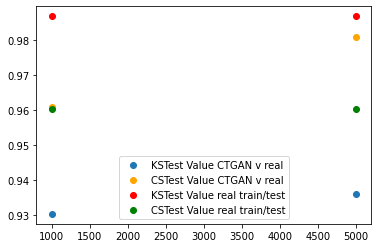

In [154]:
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['KSTest_Value_ours_v_real'], label='KSTest Value CTGAN v real')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['CSTest_Value_ours_v_real'], c='orange', label='CSTest Value CTGAN v real')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['KSTest_Value_real_train_test'], c='red', label='KSTest Value real train/test')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['CSTest_Value_real_train_test'], c='green', label='CSTest Value real train/test')
plt.legend()